### Week 2 Problem Set: Graph Theory

In this exercise we will work with real data from the C. Elegans nervous system, using data shared by the [WormAtlas](http://www.wormatlas.org/) database.  We will treat it as an undirected connectome for the purposes of this exercise.

For some problems you will be provided with skeleton code - fill in the lines marked ```...``` with appropriate code to solve problem.

In [1]:
import pandas,numpy
import os,sys
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats

from brainnetworks.utils import mk_random_graph

%matplotlib inline

# read the data from Wormatlas.org: see section 2.1 of http://www.wormatlas.org/neuronalwiring.html for details

celegans_connectome=pandas.read_excel('http://www.wormatlas.org/images/NeuronConnect.xls')

# set up the graph
Gd = nx.DiGraph()
for i in celegans_connectome.index:
    Gd.add_edge(celegans_connectome.loc[i]['Neuron 1'],celegans_connectome.loc[i]['Neuron 2'])
    
Gu=Gd.to_undirected()

# the graph has two connected components, so we will just keep the giant component
components=nx.connected_component_subgraphs(Gu)
G=next(components)


### Problem 1:

a. Plot a histogram of the degree distribution, and print out the mean and maximum degree


mean degree: 17.11743772241993
max degree: 115


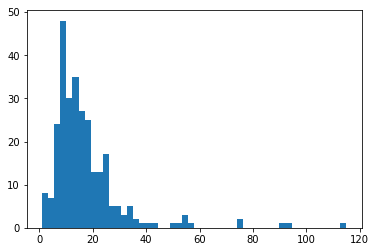

In [2]:
degree_vals = [G.degree[i] for i in G.nodes]
degree_dist = plt.hist(degree_vals, 50)
print('mean degree: {}'.format(numpy.mean(degree_vals)))
print('max degree: {}'.format(numpy.max(degree_vals)))

b. Compute the average clustering coefficient for the connectome

In [3]:
ce_clustering = nx.average_clustering(G)
print(ce_clustering)

0.34604428028046025


c. Compute the average path length for the connectome

In [4]:
ce_avgpathlength = nx.average_shortest_path_length(G)
print(ce_avgpathlength)

2.324377224199288


#### Problem 2

First, use the provided code to create 100 random graphs with the same size as the C. Elegans connectome. For each graph, we compute its average clustering, average shortest path length, and maximum degree, and store those to a numpy array. (This may take a few minutes to run.)

In [5]:
# PROVIDED CODE
nruns=100
measures=['clustering','avgpathlength','maxdegree']
results=pandas.DataFrame(numpy.zeros((nruns,len(measures))),
                        columns=measures)

for i in range(nruns):
    G_rand = mk_random_graph(G)
    results.iloc[i]['clustering']=nx.average_clustering(G_rand)
    results.iloc[i]['avgpathlength']=nx.average_shortest_path_length(G_rand)
    results.iloc[i]['maxdegree']=numpy.max([G_rand.degree[_] for _ in G_rand.nodes])
    

a.  Compute the tail probability of the observed values of cluster and path length for the C. elegans network, in comparison to the random network results.  That is, what is the probability of a value as or more extreme than the observed value wihtin the random graph distribution? You may find the function ```scipy.stats.percentileofscore()``` useful for this purpose.

In [6]:
### PROVIDED CODE: 

p_clustering=100.0 - scipy.stats.percentileofscore(results['clustering'], ce_clustering)
print('Observed:',ce_clustering,'Random:',results['clustering'].mean(),'P<',p_clustering)

p_avgpathlength=100.0 - scipy.stats.percentileofscore(results['avgpathlength'], ce_avgpathlength)
print('Observed:',ce_avgpathlength,'Random:',results['avgpathlength'].mean(),'P<',p_avgpathlength)

p_maxdegree=100.0 - scipy.stats.percentileofscore(results['maxdegree'], numpy.max(degree_vals))
print('Observed:',numpy.max(degree_vals),'Random:',results['maxdegree'].mean(),'P<',p_maxdegree)


Observed: 0.34604428028046025 Random: 0.0609618918807 P< 0.0
Observed: 2.324377224199288 Random: 2.26893289273 P< 0.0
Observed: 115 Random: 29.17 P< 0.0


Based on the results of this analysis, do you think that the C. Elegans connectome is a "small world" network"? explain your answer.

ANSWER: I think so. Two defining properties of a "small world" network include: (i) a high clustering coefficient; and (ii) a small mean-shortest path length. According to the results above (compared to the random graph distribution) the _C. Elegans_ connectome has: (i) a higher average clustering coefficient; and (ii) a slighlty higher mean-shortest path length. Note, the latter goes slightly against the "small world" network hypothesis. However, the higher max degree value provides extra support to the hypothesis that the connectome is a "small world" network.

### Problem 3:

Determine which neuron is the most important based on these four criteria:

- degree centrality
- betweenness centrality
- closeness centrality
- eigenvector centrality

Because networkx returns a dictionary when it computes centrality measures, we have provided a utility function to return the entry with the largest value.

In [7]:
### PROVIDED CODE

def get_max_from_dict(d):
    """
    return the dict entry with the max value
    after https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
    """
    return max(d, key=lambda key: d[key])

central_nodes={}
# compute degree centrality
central_nodes['degree']=get_max_from_dict(nx.degree_centrality(G))
# compute eigenvector centrality
central_nodes['eigenvector']=get_max_from_dict(nx.eigenvector_centrality(G))
# compute betweenness centrality
central_nodes['betweenness']=get_max_from_dict(nx.betweenness_centrality(G))
# compute closeness centrality
central_nodes['closeness']=get_max_from_dict(nx.closeness_centrality(G))

print(central_nodes)

{'degree': 'NMJ', 'eigenvector': 'AVAR', 'betweenness': 'NMJ', 'closeness': 'NMJ'}


You should see that the most central node differs between the different measures.  Given what you know about those measures, explain why this might be the case.

ANSWER: The degree, betweenness, and closeness centrality measures all assign 'NMJ' as the most central node. However, the eigenvector centrality measure assigns 'AVAR' as the most central node. This makes sense, because eigenvector centrality emphasizes how strongly a node influences the network (i.e., it weights more heavily nodes that are connected to other highly connected nodes). In contrast, the first three measures emphasize individual nodal properties (e.g., connectivity, influence speed, information flow control) while ignoring the properties of the other (neighboring) nodes.